# **Load Dataset**

In [58]:
!pip install torch torchvision

In [59]:
import torch
print(torch.__version__)


2.1.0+cu121


In [60]:
!pip install torch_geometric


In [61]:
import torch
from torch_geometric.datasets import Planetoid


# Load the CiteSeer dataset
citeseer_dataset = Planetoid(root='', name='CiteSeer')

citeseer = citeseer_dataset[0]

# **Split dataset**

In [62]:
from torch_geometric.transforms import RandomNodeSplit

transform = RandomNodeSplit(num_train_per_class=int(citeseer.num_nodes * 0.7), num_val=int(citeseer.num_nodes * 0.1), num_test=int(citeseer.num_nodes * 0.2))
citeseer = transform(citeseer)

# **Re-normalization Adjacency Matrix**

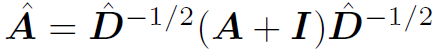

In [63]:
import numpy as np
import scipy.sparse as sp

def renormalize_adjacency(adj):

    if not isinstance(adj, sp.coo_matrix):
        adj = sp.coo_matrix(adj)

    # Add  identity matrix to adjacency matrix
    adj.setdiag(adj.diagonal() +  1)

    # degree matrix
    row_sum = adj.sum(axis=1).A1

    # inverse square root of the degree matrix
    d_inv_sqrt = np.power(row_sum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] =  0.

    #  matrix D^{-1/2}
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

    #  D^{-1/2}(A + I)D^{-1/2}
    renormalized_adjacency_matrix = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

    return renormalized_adjacency_matrix

# **DropEdge technique**

image.png

In [64]:

import torch

def calculate_A_drop(adj_matrix, deletion_rate):

    edge_indices = adj_matrix.nonzero(as_tuple=False)


    total_edges = edge_indices.size(0)


    num_edges_to_delete = int(total_edges * deletion_rate)


    permuted_indices = torch.randperm(total_edges, device=adj_matrix.device)


    indices_to_delete = edge_indices[permuted_indices[:num_edges_to_delete]]

    # Create a copy of the adjacency matrix
    modified_adj_matrix = adj_matrix.clone()

    # Delete selected edges
    modified_adj_matrix[indices_to_delete[:, 0], indices_to_delete[:, 1]] = 0

    return modified_adj_matrix





# **Important functions**

In [65]:
import torch.autograd

torch.autograd.set_detect_anomaly(True)

def train_with_get_layer_outputs(model, optimizer, criterion, data, adjacency_matrix):
    model.train()
    optimizer.zero_grad()
    out , layer_outputs = model(data.x, adjacency_matrix)  # Pass the adjacency matrix to the model
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item() , layer_outputs

def validate_with_layer_outputs(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out , _ = model(data.x, adjacency_matrix)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test_with_layer_outputs(model, criterion, data , adjacency_matrix):
    model.eval()
    with torch.no_grad():
        out , _ = model(data.x, adjacency_matrix)
        _, pred = torch.max(out, dim=1)
        correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / data.test_mask.sum().item()
    return acc


# **Eight Layer GCN (With skip connection)**

## **GCN LAYER**

In [66]:
import torch.nn as nn
import torch.nn.functional as F
import math

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.0):
        super(GCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()
        self.dropout = nn.Dropout(p=dropout)

    def reset_parameters(self):
        stdv =   1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adjacency_matrix):
        # Renormalize the adjacency matrix
        adjacency_matrix = renormalize_adjacency(adjacency_matrix.numpy())

        # Convert the renormalized adjacency matrix back to a PyTorch tensor
        adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float32)

        support = torch.mm(input, self.weight)
        output = torch.spmm(adjacency_matrix, support)
        if self.training:
            output = self.dropout(output)
        return output




## **Eight_layer_GCN**

In [72]:
class EightLayerGCN_with_skip_connection(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super(EightLayerGCN_with_skip_connection, self).__init__()
        self.layers = nn.ModuleList()

        self.layers.append(GCNLayer(in_features, hidden_features, dropout)) #first layer

        for _ in range(6):
            self.layers.append(GCNLayer(hidden_features, hidden_features, dropout)) # 6 hidden
        self.layers.append(GCNLayer(hidden_features, out_features, dropout)) # last layer

    def forward(self, input, adjacency_matrix):
        x = input
        layer_outputs = []
        for i, layer in enumerate(self.layers[:-1]):  # All layers except the last one
            x = F.relu(layer(x, adjacency_matrix))
            layer_outputs.append(x)
            # Add skip connection from the current layer to the next layer
            if i!=0 and  i +  1 < len(self.layers) -  1:

                x = x + layer_outputs[i -1]

        x = self.layers[-1](x, adjacency_matrix)
        layer_outputs.append(x)
        return x, layer_outputs

## **Prepare Adjency matrix**

In [68]:
import torch
from torch_geometric.utils import to_dense_adj


edge_index = citeseer.edge_index

#edge index to adjacency matrix

adjacency_matrix = to_dense_adj(edge_index)[0]




In [73]:
from torch import optim

torch.manual_seed(1)

model = EightLayerGCN_with_skip_connection(in_features =citeseer.num_node_features, hidden_features = 64 , out_features = citeseer_dataset.num_classes ,dropout= 0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
patience = 5
min_delta = 0.001
patience_counter = 0
best_loss = float('inf')

# Train the best model
for epoch in range(200):

    train_loss , layer_outputs = train_with_get_layer_outputs(model, optimizer, criterion, citeseer , adjacency_matrix)
    val_loss = validate_with_layer_outputs(model, criterion, citeseer , adjacency_matrix)

    # Check for improvement in validation loss
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch} \n')
            break


    print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} ')

# Evaluate the model

test_accuracy = test_with_layer_outputs(model, criterion, citeseer , adjacency_matrix)

print(f'Test Accuracy(eight layer) on citeseer dataset: {test_accuracy:.4f}')

 Epoch: 0, Train Loss: 1.7952, Validation Loss: 1.7574 
 Epoch: 1, Train Loss: 1.7533, Validation Loss: 1.7513 
 Epoch: 2, Train Loss: 1.7305, Validation Loss: 1.6897 
 Epoch: 3, Train Loss: 1.6771, Validation Loss: 1.6706 
 Epoch: 4, Train Loss: 1.6567, Validation Loss: 1.5470 
 Epoch: 5, Train Loss: 1.5217, Validation Loss: 1.3289 
 Epoch: 6, Train Loss: 1.2748, Validation Loss: 1.2165 
 Epoch: 7, Train Loss: 1.1424, Validation Loss: 1.4978 
 Epoch: 8, Train Loss: 1.3377, Validation Loss: 1.2808 
 Epoch: 9, Train Loss: 1.2516, Validation Loss: 1.1263 
 Epoch: 10, Train Loss: 1.0365, Validation Loss: 1.0885 
 Epoch: 11, Train Loss: 0.9843, Validation Loss: 1.0567 
 Epoch: 12, Train Loss: 0.9413, Validation Loss: 1.0502 
 Epoch: 13, Train Loss: 0.9256, Validation Loss: 1.0486 
 Epoch: 14, Train Loss: 0.9098, Validation Loss: 1.0106 
 Epoch: 15, Train Loss: 0.8492, Validation Loss: 0.9510 
 Epoch: 16, Train Loss: 0.7589, Validation Loss: 0.9128 
 Epoch: 17, Train Loss: 0.6834, Validatio

## **analyze oversmoothing on 8-layer gcn**

In [74]:
import matplotlib.pyplot as plt

def plot_mean_distances(all_layer_outputs, start_index=2, end_index=7):
    distances = []
    distances_before_train = []
    distances_after_train = []
    layer_outputs_before_train = all_layer_outputs[0]

    layer_outputs_after_train = all_layer_outputs[-1]

    for i in range(1 , 6):

        layer1 = layer_outputs_before_train[i]
        layer2 = layer_outputs_before_train[i+1]
        distance = torch.cdist(layer1, layer2, p=2)
        mean_distance = distance.mean().item()
        distances_before_train.append(mean_distance)


    for i in range(1 , 6):

        layer1 = layer_outputs_after_train[i]
        layer2 = layer_outputs_after_train[i+1]
        distance = torch.cdist(layer1, layer2, p=2)
        mean_distance = distance.mean().item()
        distances_after_train.append(mean_distance)
    print(distances_before_train)
    print(distances_after_train)
    # Plotting the mean distances
    plt.figure(figsize=(15,  6))
    plt.semilogy(range(start_index, end_index), distances_before_train, marker='o', label='Before Training')
    plt.semilogy(range(start_index, end_index), distances_after_train, marker='o', label='After Training(after 150 epoch)')
    plt.title('Euclidean Distances Between Consecutive Layers')
    plt.xlabel('Layer')
    plt.ylabel('Mean Distance')
    plt.xticks(range(start_index, end_index))
    plt.legend()  # Added legend to distinguish between before and after training
    plt.grid(True)
    plt.show()

In [75]:

all_layer_outputs = []

torch.manual_seed(1)


model = EightLayerGCN_with_skip_connection(in_features =citeseer.num_node_features, hidden_features = 32 , out_features = citeseer_dataset.num_classes ,dropout= 0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


output, layer_outputs = model(citeseer.x, adjacency_matrix)
all_layer_outputs.append(layer_outputs) # save layer output before train

# Train the best model
for epoch in range(150):
    train_loss , layer_outputs = train_with_get_layer_outputs(model, optimizer, criterion, citeseer , adjacency_matrix)


    print(f' Epoch: {epoch}, Train Loss: {train_loss:.4f} ')

output, layer_outputs = model(citeseer.x, adjacency_matrix)

all_layer_outputs.append(layer_outputs) # save layers output after train

 Epoch: 0, Train Loss: 1.7908 
 Epoch: 1, Train Loss: 1.7671 
 Epoch: 2, Train Loss: 1.7145 
 Epoch: 3, Train Loss: 1.6410 
 Epoch: 4, Train Loss: 1.5820 
 Epoch: 5, Train Loss: 1.5066 
 Epoch: 6, Train Loss: 1.4450 
 Epoch: 7, Train Loss: 1.3927 
 Epoch: 8, Train Loss: 1.3383 
 Epoch: 9, Train Loss: 1.2878 
 Epoch: 10, Train Loss: 1.1823 
 Epoch: 11, Train Loss: 1.1301 
 Epoch: 12, Train Loss: 1.0617 
 Epoch: 13, Train Loss: 0.9991 
 Epoch: 14, Train Loss: 0.9415 
 Epoch: 15, Train Loss: 0.9045 
 Epoch: 16, Train Loss: 0.8328 
 Epoch: 17, Train Loss: 0.7700 
 Epoch: 18, Train Loss: 0.7118 
 Epoch: 19, Train Loss: 0.6707 
 Epoch: 20, Train Loss: 0.6315 
 Epoch: 21, Train Loss: 0.6042 
 Epoch: 22, Train Loss: 0.5925 
 Epoch: 23, Train Loss: 0.5828 
 Epoch: 24, Train Loss: 0.5572 
 Epoch: 25, Train Loss: 0.5323 
 Epoch: 26, Train Loss: 0.5296 
 Epoch: 27, Train Loss: 0.5070 
 Epoch: 28, Train Loss: 0.5029 
 Epoch: 29, Train Loss: 0.4880 
 Epoch: 30, Train Loss: 0.4856 
 Epoch: 31, Train 

[0.8345986604690552, 0.8496664762496948, 0.5145182013511658, 0.4811859726905823, 0.3056749403476715]
[3.703861951828003, 5.3938398361206055, 7.899389743804932, 10.223886489868164, 16.799325942993164]


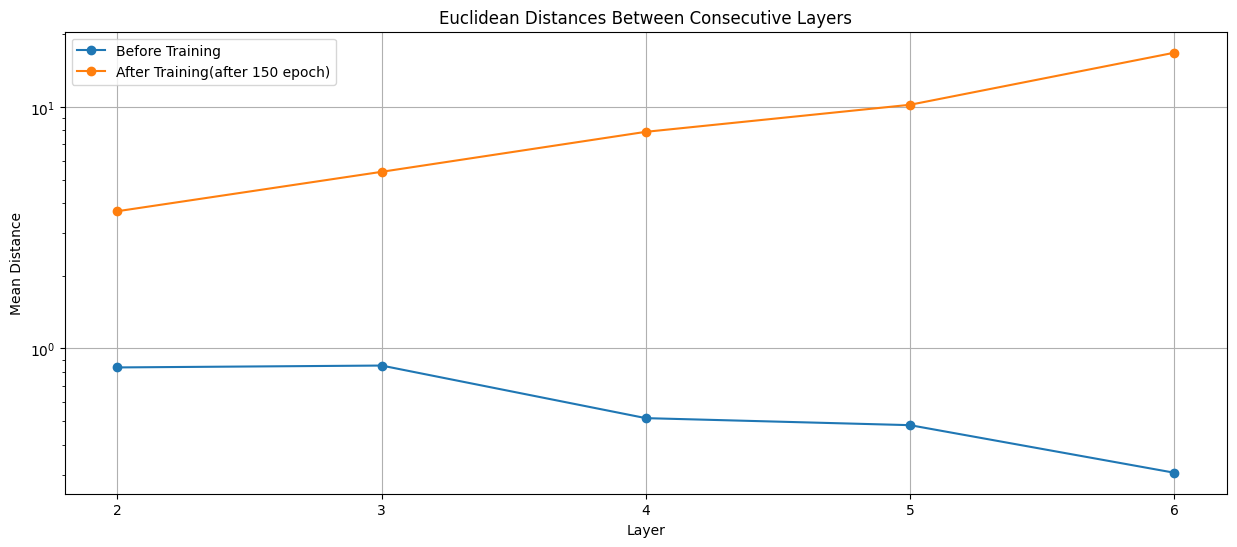

In [76]:
plot_mean_distances(all_layer_outputs)